### Multi-Layer Perceptron (MLP) as a Baseline Model
#### What is an MLP?
##### A Multi-Layer Perceptron (MLP) is a class of feedforward artificial neural networks (ANN). It consists of at least three layers:
- Input Layer – receives the input features.
- Hidden Layer(s) – where the model learns representations through nonlinear transformations.
- Output Layer – provides the final prediction (e.g., allocation score or asset return).

##### Each neuron in one layer is fully connected to the next layer, and the model learns through backpropagation, adjusting weights to minimize a loss function.

#### Why Use MLP as a Baseline in this Project? 
##### MLPs are ideal as baseline models for the following reasons:
1. Simplicity and Interpretability
MLP is a foundational deep learning model. It consists of fully connected layers and uses standard feedforward propagation. It’s relatively simple, making it ideal as a baseline to compare against more complex models like RNNs, GRUs, or Transformers. It helps us isolate the effect of dimensionality reduction techniques like PCA and autoencoders on performance.

2. Universal Function Approximator
According to the Universal Approximation Theorem, a feedforward network with a single hidden layer containing a finite number of neurons can approximate any continuous function on compact subsets of ℝⁿ, under mild assumptions on the activation function.
Mathematically: 
y = σ(W₂ * σ(W₁ * x + b₁) + b₂)
Where:
    - x is the input vector (e.g., features like returns, RSI, etc.)
    - W₁, W₂ are weight matrices
    - b₁, b₂ are biases
    - σ is the activation function (e.g., ReLU, Tanh)
    - y is the output (e.g., predicted return or portfolio allocation)


3. Compatibility with Dimensionality Reduction
MLPs perform best when the input feature space is clean and compact. Dimensionality reduction techniques like PCA and Autoencoders reduce noise and redundancy, leading to:
    - Lower overfitting risk
    - Faster training
    - Improved generalization
Thus, MLP provides a neutral ground to evaluate how much dimensionality reduction improves or degrades performance.

4. Efficient Training and Benchmarking
MLPs are computationally less expensive compared to sequence models like RNNs or GRUs. This efficiency:
    - Saves training time
    - Reduces GPU/memory load
    - Provides a quick benchmark to identify whether more complex models are worth the additional cost

5. Performance Evaluation
Using MLP as a baseline allows comparison across:
    - Accuracy / Return-based metrics (Sharpe, Sortino, Alpha)
    - Computational cost (time/memory)
    - Robustness across different reduced feature spaces

6. Loss Functions & Optimizer
    - Use MSE (Mean Squared Error) for regression outputs like portfolio returns.
    - You can also create custom loss functions to optimize metrics like Sharpe Ratio.
    - Use the Adam Optimizer for better convergence during training.

    Adam Optimizer Summary:
Adam updates weights using a combination of momentum and adaptive learning rate:
mₜ = β₁ * mₜ₋₁ + (1 - β₁) * gradient
vₜ = β₂ * vₜ₋₁ + (1 - β₂) * (gradient²)
θₜ = θₜ₋₁ - (learning_rate * mₜ) / (sqrt(vₜ) + ε)








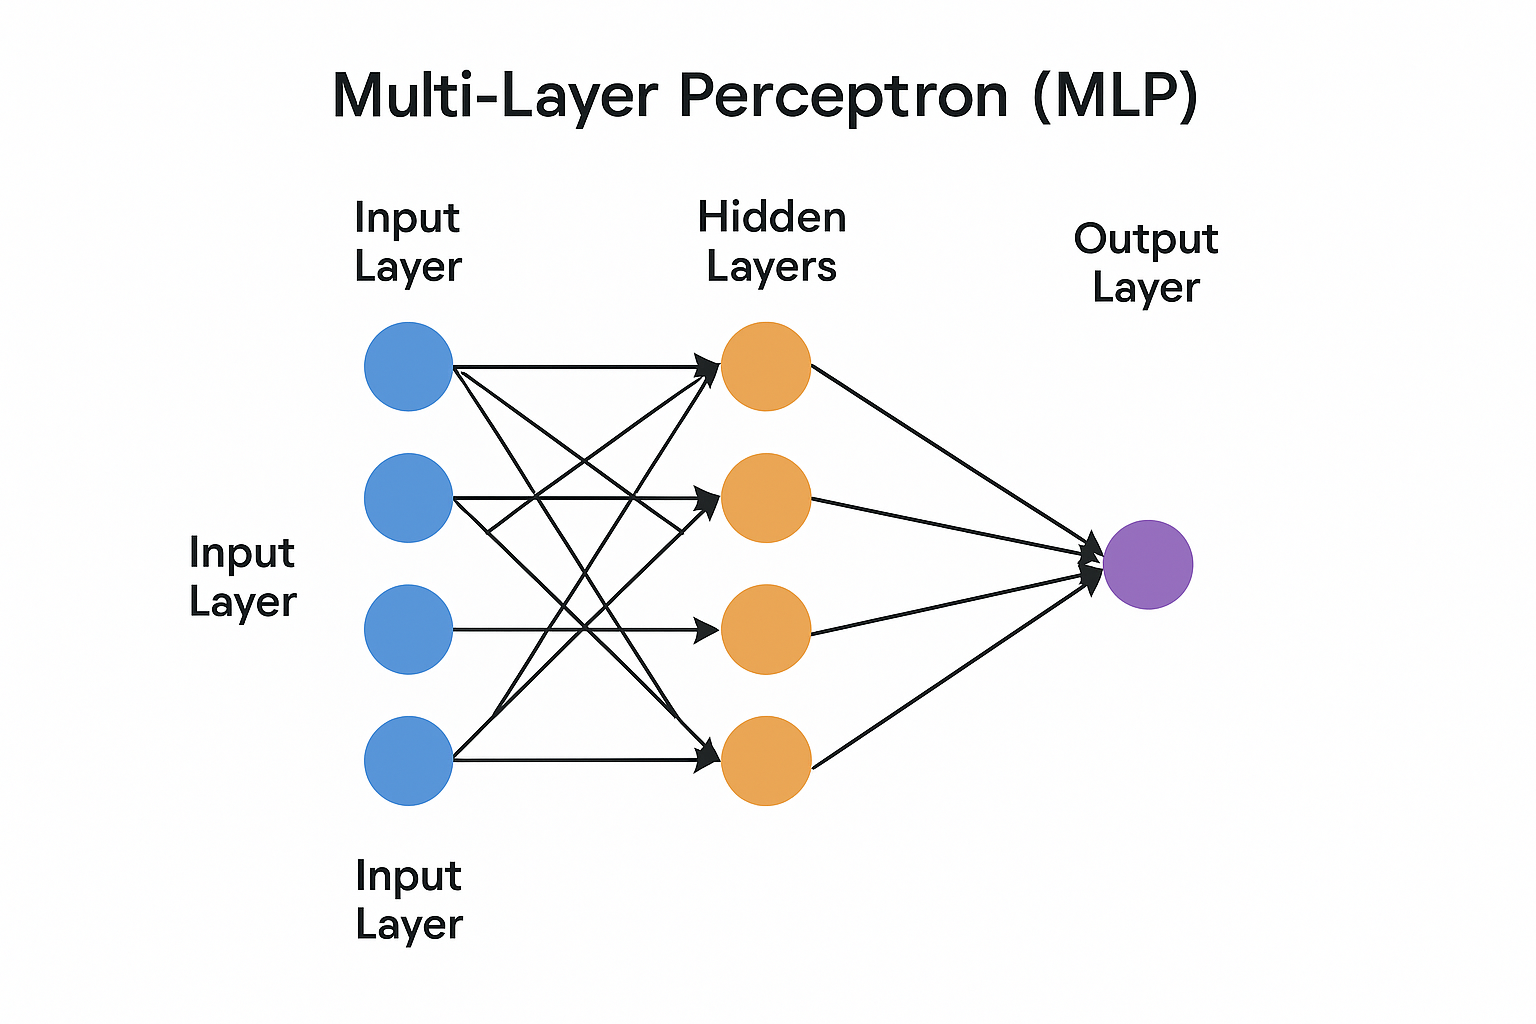

In [ ]:
from IPython.display import Image, display

# Provide the path to your image
image_path = ("/Users/imperator/Downloads/MLP.png") 

# Display the image
display(Image(filename=image_path))

In [5]:
import pandas as pd

xtrain = '/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Model Data/Pre-Dim Reduction/Training_Dataset/X_train.csv'
ytrain = '/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Model Data/Pre-Dim Reduction/Training_Dataset/y_train.csv'
X_train = pd.read_csv(xtrain)
y_train = pd.read_csv(ytrain)
X_train.shape


(13631, 40)

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import time

# ---------- CONFIGURATION ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# --- Data Loading and Preprocessing ---
data = pd.read_csv('/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5d-standardized_dataset.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']
features = ['returns', 'MACD']
lookback = 20

# ------------------------------------

# Step 1: Load data (preserve all columns)
def load_csv(path):
    return pd.read_csv(path)

# X_train = load_csv(f"{train_data_path}/X_train.csv")
# y_train = load_csv(f"{train_data_path}/y_train.csv")
# X_test = load_csv(f"{test_data_path}/X_test.csv")
# y_test = load_csv(f"{test_data_path}/y_test.csv")

# Step 2: Separate Date column if present
date_col = None
for col in X_train.columns:
    if 'date' in col.lower():
        date_col = col
        break

if date_col:
    X_train_dates = X_train[date_col]
    X_test_dates = X_test[date_col]
    # Drop date column for modeling
    X_train = X_train.drop(columns=[date_col])
    X_test = X_test.drop(columns=[date_col])
else:
    X_train_dates = None
    X_test_dates = None

# Step 3: Ensure numeric (object to numeric, handle missing values)
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')
y_train = y_train.apply(pd.to_numeric, errors='coerce')
y_test = y_test.apply(pd.to_numeric, errors='coerce')

# Fill or drop NaNs as appropriate (here, fill with 0)
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
y_train = y_train.fillna(0)
y_test = y_test.fillna(0)

# Step 4: Create validation split from training data
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False
)

# Step 5: Convert to PyTorch tensors and DataLoader
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Step 6: Define MLP model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

input_dim = X_train_tensor.shape[1]
model = MLP(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 7: Train model with early stopping and track metrics
epochs = 100
patience = 10
best_val_loss = float('inf')
counter = 0
best_model_state = model.state_dict()

tracemalloc.start()
train_start_time = time.time()
cpu_start = psutil.cpu_percent(interval=None)
memory_start = psutil.virtual_memory().used

for epoch in range(epochs):
    model.train()
    train_losses = []
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_preds = model(X_val_batch)
            val_loss = criterion(val_preds, y_val_batch)
            val_losses.append(val_loss.item())
    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print("⏹️ Early stopping triggered.")
            break


# Step 8: Metrics after training
train_end_time = time.time()
current_mem, peak_mem = tracemalloc.get_traced_memory()
cpu_end = psutil.cpu_percent(interval=None)
memory_end = psutil.virtual_memory().used
tracemalloc.stop()

training_time = train_end_time - train_start_time
memory_usage_mb = peak_mem / (1024 ** 2)
cpu_usage = cpu_end - cpu_start

print(f"\n🕒 Training Time: {training_time:.2f} seconds")
print(f"💾 Peak Memory Usage: {memory_usage_mb:.2f} MB")
print(f"🧠 CPU Usage Delta: {cpu_usage:.2f}%")

# Step 9: Save best model
model.load_state_dict(best_model_state)
output_model_path = os.path.join(base_dir,"Notebooks/deep_learning_models/Without_DR/MLP.pth")
os.makedirs(os.path.dirname(output_model_path), exist_ok=True)
torch.save(model.state_dict(), output_model_path)
print(f"✅ Best model saved to: {output_model_path}")

# Step 10: Generate predictions and save to CSV (with length alignment)
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy().flatten()
    y_true = y_test_tensor.cpu().numpy().flatten()

# Align columns before saving to CSV
if X_test_dates is not None:
    X_test_dates_aligned = pd.Series(X_test_dates).reset_index(drop=True)
    y_true_aligned = pd.Series(y_true).reset_index(drop=True)
    y_pred_aligned = pd.Series(y_pred).reset_index(drop=True)
    min_len = min(len(X_test_dates_aligned), len(y_true_aligned), len(y_pred_aligned))
    results = pd.DataFrame({
        'Date': X_test_dates_aligned[:min_len],
        'Actual': y_true_aligned[:min_len],
        'Predicted': y_pred_aligned[:min_len]
    })
else:
    results = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred})

results.to_csv('mlp_predictions.csv', index=False)
print("✅ Predictions saved to mlp_predictions.csv")

# Step 11: Evaluate predictive performance
mse = mean_squared_error(results['Actual'], results['Predicted'])
mae = mean_absolute_error(results['Actual'], results['Predicted'])
r2 = r2_score(results['Actual'], results['Predicted'])
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")


✅ Using device: cpu


NameError: name 'train_data_path' is not defined

In [3]:
data = '/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Model Data/PCA/principal_components_new.csv'
df = pd.read_csv(data)
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,Date
0,-1.559462,-3.087708,-2.796681,-1.699916,-1.750311,0.503360,-0.822235,-0.538366,0.227798,2.616844,-0.796042,-0.079339,2015-09-23
1,-1.055357,-0.688557,0.636691,-0.350601,-1.807669,0.405603,-0.382262,0.356100,0.429264,-0.464881,-0.373146,-0.415852,2015-09-23
2,-0.775588,-0.090597,0.420966,-0.506948,-1.014139,-0.254198,0.044066,-0.875864,0.934143,-0.185919,0.450258,-0.754229,2015-09-23
3,-1.266706,-1.733037,-1.083312,-1.234123,-2.166147,0.050943,0.768237,-0.927415,0.254551,2.704910,0.567278,0.269796,2015-09-23
4,0.306132,2.144931,-5.191842,-4.905424,-0.939339,-0.247824,1.014270,-0.690589,2.006861,0.040468,5.076802,7.615937,2015-09-23


In [ ]:
# drop the last column
df = df.drop(columns=['Date'])
# Display the first few rows of the DataFrame
print(df.head())

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.559462 -3.087708 -2.796681 -1.699916 -1.750311  0.503360 -0.822235   
1 -1.055357 -0.688557  0.636691 -0.350601 -1.807669  0.405603 -0.382262   
2 -0.775588 -0.090597  0.420966 -0.506948 -1.014139 -0.254198  0.044066   
3 -1.266706 -1.733037 -1.083312 -1.234123 -2.166147  0.050943  0.768237   
4  0.306132  2.144931 -5.191842 -4.905424 -0.939339 -0.247824  1.014270   

        PC8       PC9      PC10      PC11      PC12  
0 -0.538366  0.227798  2.616844 -0.796042 -0.079339  
1  0.356100  0.429264 -0.464881 -0.373146 -0.415852  
2 -0.875864  0.934143 -0.185919  0.450258 -0.754229  
3 -0.927415  0.254551  2.704910  0.567278  0.269796  
4 -0.690589  2.006861  0.040468  5.076802  7.615937  


In [8]:
# save to the save csv path
save_path = '/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Model Data/PCA/principal_components_new.csv'
df.to_csv(save_path, index=False)

In [9]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import time, os, psutil

# --- Utility Functions ---
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 ** 3)  # in GB

def get_gpu_memory():
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated() / (1024 ** 3)  # in GB
    return 0

# --- Load PCA Data ---
# Replace this path with your PCA CSV file path
pca_features_path = '/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Model Data/PCA/principal_components_new.csv'
target_path = '/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Model Data/Pre-Dim Reduction/Training_Dataset/y_train.csv'  # Should match rows of PCA features

# Load PCA features and targets
X_pca = pd.read_csv(pca_features_path).values.astype(np.float32)
y = pd.read_csv(target_path).values.astype(np.float32)  # shape: (samples, n_assets)

# Convert to torch tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_tensor = torch.tensor(X_pca, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

# Train/test split (80/20)
split_idx = int(0.8 * len(X_tensor))
X_train, X_test = X_tensor[:split_idx], X_tensor[split_idx:]
y_train, y_test = y_tensor[:split_idx], y_tensor[split_idx:]

# --- MLP Model ---
class PortfolioMLP(nn.Module):
    def __init__(self, input_dim, n_assets):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, n_assets)
        )
    def forward(self, x):
        return torch.softmax(self.net(x), dim=1)

n_assets = y.shape[1]
input_dim = X_pca.shape[1]
model = PortfolioMLP(input_dim, n_assets).to(device)

# --- Training Setup ---
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# --- Sharpe Ratio Loss ---
def sharpe_loss(portfolio_returns):
    return -torch.mean(portfolio_returns) / (torch.std(portfolio_returns) + 1e-6)

# --- Portfolio Evaluation ---
def evaluate_portfolio(model, X, y, cost_rate=0.0005):
    model.eval()
    portfolio_values = [1.0]
    prev_weights = None
    returns = []
    with torch.no_grad():
        for i in range(len(X)):
            weights = model(X[i].unsqueeze(0))
            raw_return = torch.sum(weights * y[i]).item()
            if prev_weights is not None:
                turnover = torch.sum(torch.abs(weights - prev_weights)).item()
                raw_return -= cost_rate * turnover
            portfolio_values.append(portfolio_values[-1] * (1 + raw_return))
            returns.append(raw_return)
            prev_weights = weights.clone()
    returns = np.array(returns)
    portfolio_values = np.array(portfolio_values)
    sharpe = np.mean(returns) / (np.std(returns) + 1e-9)
    peak = np.maximum.accumulate(portfolio_values)
    drawdown = (peak - portfolio_values) / peak
    max_drawdown = np.max(drawdown)
    ann_return = (portfolio_values[-1] / portfolio_values[0]) ** (252 / len(returns)) - 1
    ann_vol = np.std(returns) * np.sqrt(252)
    return {
        'sharpe': sharpe,
        'max_drawdown': max_drawdown,
        'annualized_return': ann_return,
        'annualized_vol': ann_vol,
        'cumulative_returns': portfolio_values,
        'returns': returns
    }

# --- Training Loop ---
epochs = 100
batch_size = 64

model.train()
start_time = time.time()
for epoch in range(epochs):
    optimizer.zero_grad()
    weights = model(X_train)
    portfolio_returns = torch.sum(weights * y_train, dim=1)
    loss = sharpe_loss(portfolio_returns)
    mse_loss = criterion(weights, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Sharpe={-loss.item():.4f}, MSE={mse_loss.item():.6f}")
train_time = time.time() - start_time

# --- Evaluation ---
test_mse = criterion(model(X_test), y_test).item()
results = evaluate_portfolio(model, X_test, y_test)

print("\nEvaluation Metrics:")
print(f"- Training time: {train_time:.2f} seconds")
print(f"- Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"- GPU memory used: {get_gpu_memory():.2f} GB")
print(f"- RAM usage: {get_memory_usage():.2f} GB")
print(f"- Test MSE: {test_mse:.6f}")
print(f"- Test Sharpe Ratio: {results['sharpe']:.4f}")
print(f"- Test Annualized Return: {results['annualized_return']:.2%}")
print(f"- Test Annualized Volatility: {results['annualized_vol']:.2%}")
print(f"- Test Max Drawdown: {results['max_drawdown']:.2%}")


RuntimeError: The size of tensor a (2376704) must match the size of tensor b (11685) at non-singleton dimension 0

In [21]:
# Load the .pth file as a dictionary
checkpoint = torch.load("/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/Notebooks/deep_learning_models/Without_DR/MLP.pth")

# Load the state_dict (weights and biases)
state_dict = checkpoint

# Print the weights in an aligned format
print(f"{'Layer Name':<30} {'Shape':<20}")
print("-" * 50)
for layer_name, weight in state_dict.items():
    print(f"{layer_name:<30} {str(weight.shape):<20}")

Layer Name                     Shape               
--------------------------------------------------
model.0.weight                 torch.Size([128, 85])
model.0.bias                   torch.Size([128])   
model.3.weight                 torch.Size([64, 128])
model.3.bias                   torch.Size([64])    
model.6.weight                 torch.Size([1, 64]) 
model.6.bias                   torch.Size([1])     


### Evaluating Metrics (RMSE, MAE, R²,)

In [22]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# -------- CONFIGURATION --------
test_data_path = "/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Model Data/Pre-Dim Reduction/Test_Dataset"  # 🔁 UPDATE this path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# -------------------------------

# 1. Load test features and labels
X_test = pd.read_csv(f"{test_data_path}/X_test.csv")
y_test = pd.read_csv(f"{test_data_path}/y_test.csv")

# 2. Ensure numeric and align
X_test = X_test.apply(pd.to_numeric, errors='coerce').dropna()
y_test = y_test.apply(pd.to_numeric, errors='coerce')
y_test = y_test.reindex(X_test.index).dropna()
X_test = X_test.reindex(y_test.index)

# 3. Check for empty datasets
if X_test.empty or y_test.empty:
    raise ValueError("🚨 X_test or y_test is empty after preprocessing!")

# 4. Convert to tensors
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

# 5. Predict using trained model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy().flatten()
    y_actual = y_test_tensor.cpu().numpy().flatten()

# 6. Evaluation Metrics
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
mae = mean_absolute_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

print("\n📊 Model Performance on Test Set:")
print(f"🔹 RMSE: {rmse:.6f}")
print(f"🔹 MAE : {mae:.6f}")
print(f"🔹 R²  : {r2:.6f}")

# 7. Line Plot of Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_actual, label='Actual Returns', linewidth=1.5)
plt.plot(y_pred, label='Predicted Returns', linestyle='--', linewidth=1.5)
plt.title("📈 Actual vs Predicted Returns (Time Series)")
plt.xlabel("Time Index")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Scatter Plot of Predictions vs Actuals
plt.figure(figsize=(6, 6))
plt.scatter(y_actual, y_pred, alpha=0.5)
plt.title("🔍 Predicted vs Actual Returns (Scatter)")
plt.xlabel("Actual Return")
plt.ylabel("Predicted Return")
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], 'r--')  # 45-degree line
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: 🚨 X_test or y_test is empty after preprocessing!

### Visualizing the Training/Validation Loss

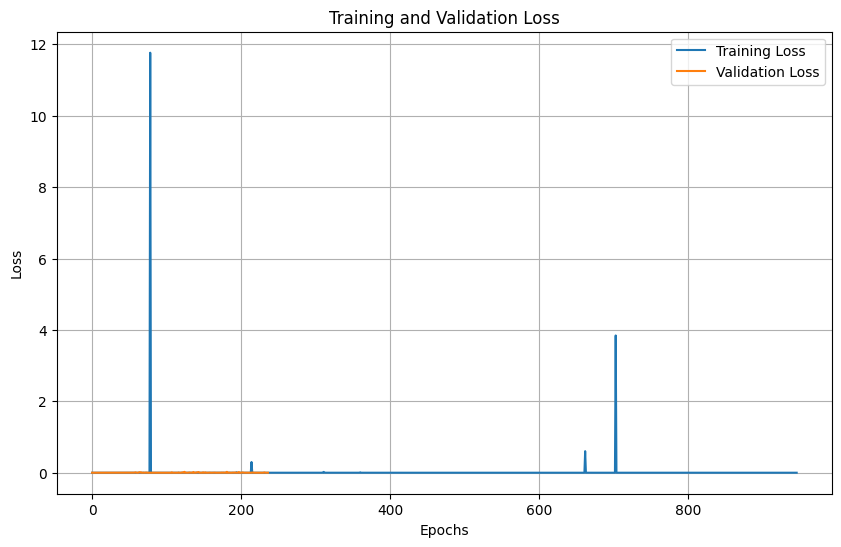

In [23]:
import matplotlib.pyplot as plt

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

### Financial Metrics

In [24]:
import numpy as np

# Assuming y_test_actual and y_test_pred are the actual and predicted returns
risk_free_rate = 0.02 
daily_risk_free_rate = risk_free_rate / 252

# Calculate excess returns
excess_returns = y_test_pred.flatten() - risk_free_rate

# Sharpe Ratio
sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)

# Sortino Ratio
downside_returns = excess_returns[excess_returns < 0]
downside_deviation = np.std(downside_returns)
sortino_ratio = np.mean(excess_returns) / downside_deviation

# Maximum Drawdown
cumulative_returns = np.cumsum(y_test_pred.flatten())
drawdowns = cumulative_returns - np.maximum.accumulate(cumulative_returns)
max_drawdown = np.min(drawdowns)

# Cumulative Return
cumulative_return = np.sum(y_test_pred.flatten())

# Print results
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Sortino Ratio: {sortino_ratio:.4f}")
print(f"Maximum Drawdown: {max_drawdown:.4f}")
print(f"Cumulative Return: {cumulative_return:.4f}")

NameError: name 'y_test_pred' is not defined

In [25]:
import matplotlib.pyplot as plt

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label="Cumulative Returns")
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.title("Cumulative Returns Over Time")
plt.legend()
plt.grid()
plt.show()

NameError: name 'cumulative_returns' is not defined

<Figure size 1000x600 with 0 Axes>

### Portfolio Weight Prediction

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the trained model
model = MLP_best_model(input_dim)  # Ensure the architecture matches the saved model
model.load_state_dict(torch.load("MLP_best_model.pth"))
model.eval()

# Prepare new data for prediction
new_data = pd.read_csv("new_data.csv")  # Replace with your new dataset
new_data_scaled = scaler.transform(new_data.values)  # Use the same scaler as training
new_data_tensor = torch.tensor(new_data_scaled, dtype=torch.float32).to(device)

# Predict portfolio weights
with torch.no_grad():
    portfolio_weights = model(new_data_tensor).cpu().numpy()

# Ensure weights are non-negative and sum to 1
portfolio_weights = np.maximum(portfolio_weights, 0)  # Remove negative weights
portfolio_weights /= np.sum(portfolio_weights)  # Normalize to sum to 1

# Export portfolio weights to Excel
assets = ["Asset 1", "Asset 2", "Asset 3", "Asset 4"]  # Replace with your asset names
portfolio_df = pd.DataFrame({
    "Asset": assets,
    "Weight": portfolio_weights.flatten()
})
portfolio_df.to_excel("portfolio_weights.xlsx", index=False)
print("✅ Portfolio weights exported to 'portfolio_weights.xlsx'")

# Visualize portfolio weights
plt.figure(figsize=(10, 6))
plt.bar(assets, portfolio_weights.flatten(), color="skyblue")
plt.xlabel("Assets")
plt.ylabel("Portfolio Weights")
plt.title("Predicted Portfolio Weights")
plt.grid(axis="y")
plt.show()

NameError: name 'MLP_best_model' is not defined

In [10]:
data = '/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5b-selected_features_dataset.csv'
df = pd.read_csv(data)
df.columns

Index(['Ticker', 'Date', 'Close', 'Open', 'High', 'EMA_10', 'RSI_14', 'MACD',
       'ADX_14', 'DMI_plus_14', 'DMI_minus_14', 'treasury_10y',
       'nonfarm_payrolls', 'cpi', 'baa_yield', 'returns'],
      dtype='object')

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim

# 1. Load Data
# df = pd.read_csv('/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5b-selected_features_dataset.csv')
df = pd.read_csv('/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/6b-standardized_etf_data copy.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Date', 'Ticker']).reset_index(drop=True)

# 2. Pivot to get (date x asset) matrix of returns
assets = df['Ticker'].unique().tolist()
features = ['High', 'Low', 'Open', 'Volume', 'returns',
       'EMA_10', 'EMA_50', 'MACD', 'MACD_Signal', 'RSI_14', 'ATR_14',
       'Volatility_21', 'OBV', 'Max_Drawdown_21', 'Calmar_Ratio_21', 'Beta',
       'Alpha', 'ADX_14', 'DMI_plus_14', 'DMI_minus_14', 'cpi', 'core_cpi',
       'pce_price_index', 'real_gdp', 'industrial_production',
       'durable_goods_orders', 'unemployment_rate', 'nonfarm_payrolls',
       'jobless_claims', 'fed_funds_rate', 'treasury_10y', 'treasury_3m',
       'baa_yield', 'aaa_yield', 'consumer_credit', 'mortgage_rate_30y',
       'housing_starts', 'building_permits', 'new_home_sales',
       'umich_consumer_sentiment']
target = ['Close']

# Build feature tensor: (n_samples, n_assets, n_features)
dates = df['Date'].unique()
X = []
y = []
date_list = []
for date in dates[:-1]:  # leave last date for prediction
    day_data = df[df['Date'] == date]
    next_day_data = df[df['Date'] == pd.Timestamp(date) + pd.Timedelta(days=1)]
    if len(day_data) == len(assets) and len(next_day_data) == len(assets):
        X.append(day_data[features].values)
        y.append(next_day_data.set_index('Ticker').loc[assets][target].values)
        date_list.append(date)
X = np.array(X)  # (n_samples, n_assets, n_features)
y = np.array(y)  # (n_samples, n_assets)
date_list = np.array(date_list)

# 3. Standardize features
n_samples, n_assets, n_features = X.shape
X_reshaped = X.reshape(-1, n_features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped).reshape(n_samples, n_assets, n_features)

# 4. PCA per asset
X_pca = []
n_components = min(5, n_features)
for i in range(n_assets):
    pca = PCA(n_components=n_components, random_state=42)
    X_pca.append(pca.fit_transform(X_scaled[:, i, :]))
X_pca = np.stack(X_pca, axis=1)  # (n_samples, n_assets, n_components)

# 5. Train-test split
split_date = pd.to_datetime('2018-01-01')
train_mask = date_list < split_date
test_mask = date_list >= split_date

X_train, X_test = X_pca[train_mask], X_pca[test_mask]
y_train, y_test = y[train_mask], y[test_mask]
dates_test = date_list[test_mask]

# 6. Prepare for MLP
X_train_t = torch.tensor(X_train.reshape(X_train.shape[0], -1), dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test.reshape(X_test.shape[0], -1), dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

# 7. Define MLP
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[128, 64], dropout=0.2):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims)-1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(dims[-1], output_dim))
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp = MLP(input_dim=X_train_t.shape[1], output_dim=n_assets).to(device)
optimizer = optim.Adam(mlp.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
X_train_t, y_train_t = X_train_t.to(device), y_train_t.to(device)
X_test_t, y_test_t = X_test_t.to(device), y_test_t.to(device)

# 8. Train
epochs = 100
batch_size = 64
mlp.train()
for epoch in range(epochs):
    perm = torch.randperm(X_train_t.size(0))
    epoch_loss = 0
    for i in range(0, X_train_t.size(0), batch_size):
        idx = perm[i:i+batch_size]
        Xb, yb = X_train_t[idx], y_train_t[idx]
        pred = mlp(Xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * Xb.size(0)
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss/X_train_t.size(0):.6f}")

# 9. Predict
mlp.eval()
with torch.no_grad():
    y_pred_test = mlp(X_test_t).cpu().numpy()

# 10. Portfolio weights (softmax)
def get_weights(pred_returns, temperature=1.5):
    exp_pred = np.exp(pred_returns / temperature)
    return exp_pred / exp_pred.sum(axis=1, keepdims=True)

weights = get_weights(y_pred_test, temperature=1.5)  # (n_samples, n_assets)

# 11. Portfolio backtest
portfolio_returns = np.sum(weights * y_test, axis=1)
cumulative_returns = np.cumprod(1 + portfolio_returns)

# 12. Metrics
sharpe = np.mean(portfolio_returns) / (np.std(portfolio_returns) + 1e-9)
sortino = np.mean(portfolio_returns) / (np.std(portfolio_returns[portfolio_returns < 0]) + 1e-9)
drawdowns = (np.maximum.accumulate(cumulative_returns) - cumulative_returns) / np.maximum.accumulate(cumulative_returns)
max_drawdown = drawdowns.max()
annualized_return = np.prod(1 + portfolio_returns) ** (252 / len(portfolio_returns)) - 1
annualized_vol = np.std(portfolio_returns) * np.sqrt(252)
calmar = annualized_return / max_drawdown if max_drawdown > 0 else 0

print("\nPerformance Report")
print("="*30)
print(f"Test Sharpe Ratio: {sharpe:.4f}")
print(f"Sortino Ratio: {sortino:.4f}")
print(f"Calmar Ratio: {calmar:.4f}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_vol:.2%}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print("="*30)

# 13. Visualization: Average weights per asset
avg_weights = weights.mean(axis=0)
plt.figure(figsize=(10, 6))
plt.bar(assets, avg_weights)
plt.title("Average Portfolio Weights (Test Period)")
plt.ylabel("Average Weight")
plt.xlabel("Asset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 7))
plt.pie(avg_weights, labels=assets, autopct='%1.1f%%', startangle=90)
plt.title("Average Portfolio Allocation (Test Period)")
plt.axis('equal')
plt.show()


RuntimeError: The size of tensor a (64) must match the size of tensor b (8) at non-singleton dimension 1

In [15]:
data = '/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/6a-standardized_etf_data copy.csv'
df = pd.read_csv(data)
df.columns

Index(['Date', 'Ticker', 'Close', 'High', 'Low', 'Open', 'Volume', 'returns',
       'EMA_10', 'EMA_50', 'MACD', 'MACD_Signal', 'RSI_14', 'ATR_14',
       'Volatility_21', 'OBV', 'Max_Drawdown_21', 'Calmar_Ratio_21', 'Beta',
       'Alpha', 'ADX_14', 'DMI_plus_14', 'DMI_minus_14', 'cpi', 'core_cpi',
       'pce_price_index', 'real_gdp', 'industrial_production',
       'durable_goods_orders', 'unemployment_rate', 'nonfarm_payrolls',
       'jobless_claims', 'fed_funds_rate', 'treasury_10y', 'treasury_3m',
       'baa_yield', 'aaa_yield', 'consumer_credit', 'mortgage_rate_30y',
       'housing_starts', 'building_permits', 'new_home_sales',
       'umich_consumer_sentiment', 'returns_winsorized'],
      dtype='object')

Epoch 0: Train Sharpe=0.0382, Val Sharpe=-0.0673, MSE=0.743706
Epoch 10: Train Sharpe=0.1307, Val Sharpe=-0.0866, MSE=0.733835
Epoch 20: Train Sharpe=0.2229, Val Sharpe=-0.1029, MSE=0.725654
Epoch 30: Train Sharpe=0.3314, Val Sharpe=-0.1060, MSE=0.716706
Epoch 40: Train Sharpe=0.4435, Val Sharpe=-0.0978, MSE=0.705853
Early stopping at epoch 50

Evaluation Metrics:
- Training time: 1.50 seconds
- Device: CPU
- RAM usage: 0.47 GB
- Test MSE: 0.881626
- Test Sharpe Ratio: -0.0033
- Test Sortino Ratio: -0.0050
- Test Calmar Ratio: -0.6493
- Test Annualized Return: -100.00%
- Test Annualized Volatility: 1490.54%
- Test Max Drawdown: 154.01%


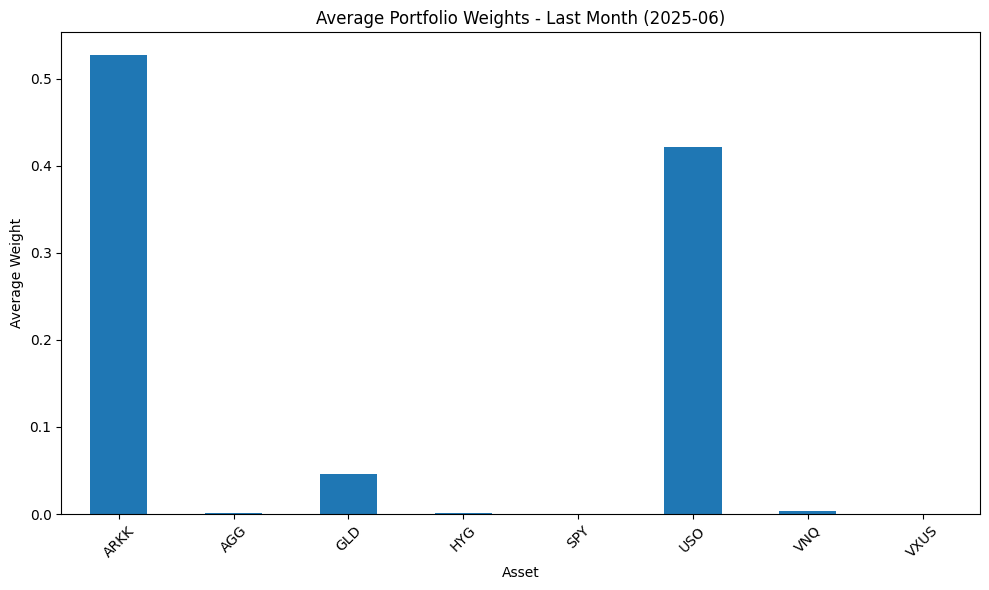

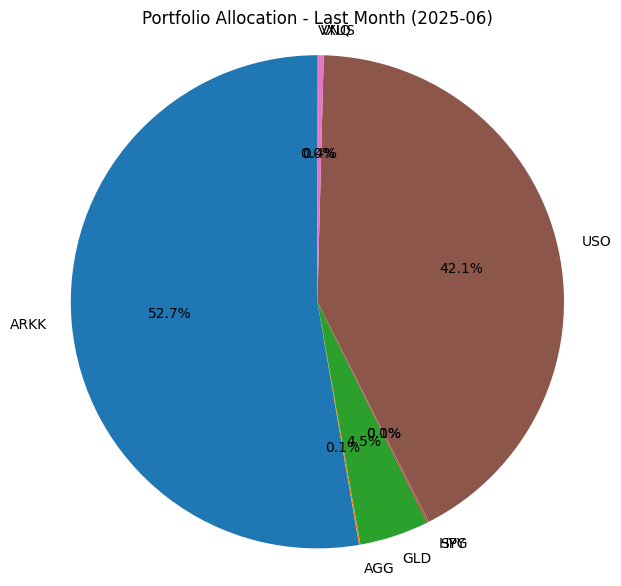

In [27]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time
import psutil

# --- Utility Functions ---
def get_memory_usage():
    process = psutil.Process()
    return process.memory_info().rss / (1024 ** 3)  # GB

def sortino_ratio(returns, risk_free_rate=0.0, periods_per_year=252):
    downside_returns = returns[returns < risk_free_rate]
    expected_return = np.mean(returns) - risk_free_rate
    downside_std = np.std(downside_returns)
    return expected_return / (downside_std + 1e-9)

def calmar_ratio(returns):
    cumulative = np.cumprod(1 + returns)
    peak = np.maximum.accumulate(cumulative)
    drawdown = (peak - cumulative) / peak
    max_drawdown = np.max(drawdown)
    ann_return = (cumulative[-1] / cumulative[0]) ** (252 / len(returns)) - 1
    return ann_return / (max_drawdown + 1e-9) if max_drawdown > 0 else np.nan

def annualized_return(returns, periods_per_year=252):
    compounded_growth = np.prod(1 + returns)
    n_periods = len(returns)
    return compounded_growth ** (periods_per_year / n_periods) - 1 if n_periods > 0 else 0.0

def annualized_volatility(returns, periods_per_year=252):
    return np.std(returns) * np.sqrt(periods_per_year)

def sharpe_ratio(returns, risk_free_rate=0.0, periods_per_year=252):
    ann_return = annualized_return(returns, periods_per_year)
    ann_vol = annualized_volatility(returns, periods_per_year)
    return (ann_return - risk_free_rate) / (ann_vol + 1e-9)

# --- Load Data ---
data = pd.read_csv('/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5d-standardized_dataset.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']
features = ['returns', 'MACD']

lookback = 30
X_list, y_list, dates_list = [], [], []
all_dates = sorted(data['Date'].unique())

for i in range(lookback, len(data)):
    cur_date = data.iloc[i]['Date']
    day_slice = data[data['Date'] == cur_date]
    if set(assets) <= set(day_slice['Ticker']):
        X_i = []
        valid = True
        for asset in assets:
            asset_slice = data[(data['Ticker'] == asset) & (data['Date'] <= cur_date)].tail(lookback)
            if len(asset_slice) == lookback:
                X_i.append(asset_slice[features].values)
            else:
                valid = False
                break
        if valid:
            cur_idx = all_dates.index(cur_date)
            if cur_idx + 1 < len(all_dates):
                next_date = all_dates[cur_idx + 1]
                next_returns = []
                for asset in assets:
                    next_row = data[(data['Date'] == next_date) & (data['Ticker'] == asset)]
                    if not next_row.empty:
                        next_returns.append(next_row['returns'].values[0])
                    else:
                        valid = False
                        break
                if valid:
                    X_i = np.stack(X_i, axis=1)  # (lookback, n_assets, n_features)
                    X_list.append(X_i)
                    y_list.append(next_returns)
                    dates_list.append(cur_date)

X = np.array(X_list)  # shape: (samples, lookback, n_assets, n_features)
y = np.array(y_list)  # shape: (samples, n_assets)
dates = np.array(dates_list)

# --- Chronological Train/Val/Test Split (60/20/20) ---
n_samples = X.shape[0]
train_idx = int(0.6 * n_samples)
val_idx = int(0.8 * n_samples)

X_train, X_val, X_test = X[:train_idx], X[train_idx:val_idx], X[val_idx:]
y_train, y_val, y_test = y[:train_idx], y[train_idx:val_idx], y[val_idx:]
dates_train, dates_val, dates_test = dates[:train_idx], dates[train_idx:val_idx], dates[val_idx:]

# --- Scaling: Fit ONLY on Training Data ---
def reshape_for_scaler(X):
    s, lb, na, nf = X.shape
    return X.reshape(s * lb * na, nf)

def reshape_back(X_scaled, s, lb, na, nf):
    return X_scaled.reshape(s, lb, na, nf)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(reshape_for_scaler(X_train))
X_val_scaled = scaler.transform(reshape_for_scaler(X_val))
X_test_scaled = scaler.transform(reshape_for_scaler(X_test))

# Reshape back to original shape
X_train_scaled = reshape_back(X_train_scaled, *X_train.shape)
X_val_scaled = reshape_back(X_val_scaled, *X_val.shape)
X_test_scaled = reshape_back(X_test_scaled, *X_test.shape)

# Flatten lookback, assets, features for MLP
X_train_final = X_train_scaled.reshape(X_train.shape[0], -1)
X_val_final = X_val_scaled.reshape(X_val.shape[0], -1)
X_test_final = X_test_scaled.reshape(X_test.shape[0], -1)

# --- Convert to tensors ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_t = torch.tensor(X_train_final, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_t = torch.tensor(X_val_final, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test_final, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).to(device)

# --- MLP Model ---
class PortfolioMLP(nn.Module):
    def __init__(self, input_dim, n_assets, temperature=0.5):
        super().__init__()
        self.temperature = temperature
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, n_assets)
        )
    def forward(self, x):
        logits = self.net(x)
        return torch.softmax(logits / self.temperature, dim=1)

input_dim = X_train_final.shape[1]
model = PortfolioMLP(input_dim, len(assets), temperature=0.5).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
criterion = nn.MSELoss()

def sharpe_loss(portfolio_returns):
    return -torch.mean(portfolio_returns) / (torch.std(portfolio_returns) + 1e-6)

# --- Training Loop with Timing ---
epochs = 100
patience = 50
best_val_sharpe = -np.inf
patience_counter = 0
mlp_losses, train_sharpes, val_sharpes = [], [], []

start_time = time.time()
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    weights = model(X_train_t)
    portfolio_returns = torch.sum(weights * y_train_t, dim=1)
    loss = sharpe_loss(portfolio_returns)
    mse_loss = criterion(weights, y_train_t)
    loss.backward()
    optimizer.step()
    mlp_losses.append(loss.item())
    train_sharpes.append(-loss.item())
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_weights = model(X_val_t)
        val_portfolio_returns = torch.sum(val_weights * y_val_t, dim=1)
        val_sharpe = np.mean(val_portfolio_returns.cpu().numpy()) / (np.std(val_portfolio_returns.cpu().numpy()) + 1e-9)
        val_sharpes.append(val_sharpe)
    
    # Early stopping
    if val_sharpe > best_val_sharpe:
        best_val_sharpe = val_sharpe
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Sharpe={-loss.item():.4f}, Val Sharpe={val_sharpe:.4f}, MSE={mse_loss.item():.6f}")
train_time = time.time() - start_time

# Load best model
model.load_state_dict(best_model_state)

# --- Portfolio Evaluation Function ---
def evaluate_portfolio(model, X, y, dates, cost_rate=0.0005):
    model.eval()
    portfolio_values = [1.0]
    weights_history = []
    returns = []
    prev_weights = None
    with torch.no_grad():
        for i in range(len(X)):
            weights = model(X[i].unsqueeze(0))
            raw_return = torch.sum(weights * y[i]).item()
            if prev_weights is not None:
                turnover = torch.sum(torch.abs(weights - prev_weights)).item()
                raw_return -= cost_rate * turnover
            portfolio_values.append(portfolio_values[-1] * (1 + raw_return))
            weights_history.append(weights.squeeze().cpu().numpy())
            returns.append(raw_return)
            prev_weights = weights.clone()
    returns = np.array(returns)
    portfolio_values = np.array(portfolio_values)
    sharpe = np.mean(returns) / (np.std(returns) + 1e-9)
    peak = np.maximum.accumulate(portfolio_values)
    drawdown = (peak - portfolio_values) / peak
    max_drawdown = np.max(drawdown)
    ann_return = (portfolio_values[-1] / portfolio_values[0]) ** (252 / len(returns)) - 1
    ann_vol = np.std(returns) * np.sqrt(252)
    return {
        'sharpe': sharpe,
        'max_drawdown': max_drawdown,
        'annualized_return': ann_return,
        'annualized_vol': ann_vol,
        'cumulative_returns': portfolio_values,
        'weights': np.array(weights_history),
        'dates': dates,
        'returns': returns
    }

# --- Evaluation ---
test_results = evaluate_portfolio(model, X_test_t, y_test_t, dates_test)
test_weights = np.array(test_results['weights'])
test_returns = np.array(test_results['returns'])

# --- Metrics ---
mse = np.mean((test_returns - np.mean(test_returns))**2)
sortino = sortino_ratio(test_returns)
calmar = calmar_ratio(test_returns)

print("\nEvaluation Metrics:")
print(f"- Training time: {train_time:.2f} seconds")
print(f"- Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
print(f"- RAM usage: {get_memory_usage():.2f} GB")
print(f"- Test MSE: {mse:.6f}")
print(f"- Test Sharpe Ratio: {test_results['sharpe']:.4f}")
print(f"- Test Sortino Ratio: {sortino:.4f}")
print(f"- Test Calmar Ratio: {calmar:.4f}")
print(f"- Test Annualized Return: {test_results['annualized_return']:.2%}")
print(f"- Test Annualized Volatility: {test_results['annualized_vol']:.2%}")
print(f"- Test Max Drawdown: {test_results['max_drawdown']:.2%}")

# --- Visualization: Average Weights for Last Month ---
test_dates = pd.to_datetime(pd.Series(test_results['dates']))
weights = np.array(test_results['weights'])
weights_df = pd.DataFrame(weights, columns=assets, index=test_dates)
last_month = weights_df.index.max().to_period('M')
mask = weights_df.index.to_series().dt.to_period('M') == last_month
last_month_weights = weights_df[mask]
avg_last_month_weights = last_month_weights.mean(axis=0)

plt.figure(figsize=(10, 6))
avg_last_month_weights.plot(kind='bar')
plt.title(f"Average Portfolio Weights - Last Month ({last_month})")
plt.ylabel("Average Weight")
plt.xlabel("Asset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 7))
plt.pie(avg_last_month_weights, labels=assets, autopct='%1.1f%%', startangle=90)
plt.title(f"Portfolio Allocation - Last Month ({last_month})")
plt.axis('equal')
plt.show()
